# **Importing Libraries :**

In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from scipy.sparse import csr_matrix
import scipy
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
from collections import Counter
from matplotlib import font_manager
import warnings
warnings.filterwarnings("ignore")

# **Reading the Traing Dataset :**

#### Input the train DataSet that contains at least : seller_item_name , price and sku columns

In [2]:
# replace the Excel path & the sheet name with the one you want
df = pd.read_excel("Product Matching Dataset.xlsx" , sheet_name="Dataset")  
df.head()

,sku,marketplace_product_name_ar,seller_item_name,price
0,1322,استوهالت 40 مجم 14 كبسول,ESTOHALT 40 MG 14 CAP,56.5
1,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
2,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
3,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
4,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5


# **Statistical Analysis :**

In [3]:
df.shape

(83562, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83562 entries, 0 to 83561
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sku                          83562 non-null  int64  
 1   marketplace_product_name_ar  83562 non-null  object 
 2   seller_item_name             83562 non-null  object 
 3   price                        83562 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ MB


In [5]:
df.describe()

,sku,price
count,83562.000000,83562.000000
mean,1600.653204,79.055458
std,1469.206223,62.818117
min,4.000000,7.000000
25%,476.000000,38.000000
50%,1312.000000,61.500000
75%,2258.000000,100.500000
max,9532.000000,406.000000


In [6]:
df.isna().sum()

sku                            0
marketplace_product_name_ar    0
seller_item_name               0
price                          0
dtype: int64

# **Visualized Analysis :**

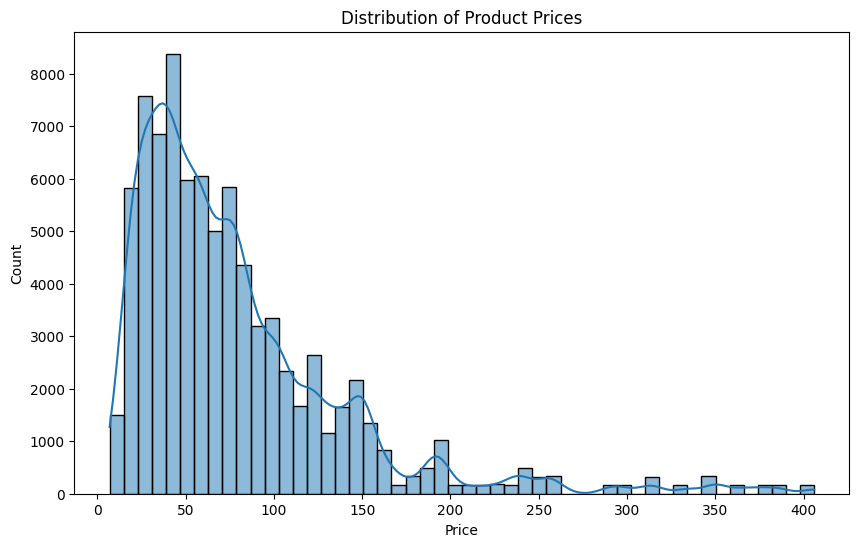

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Product Prices')
plt.show()


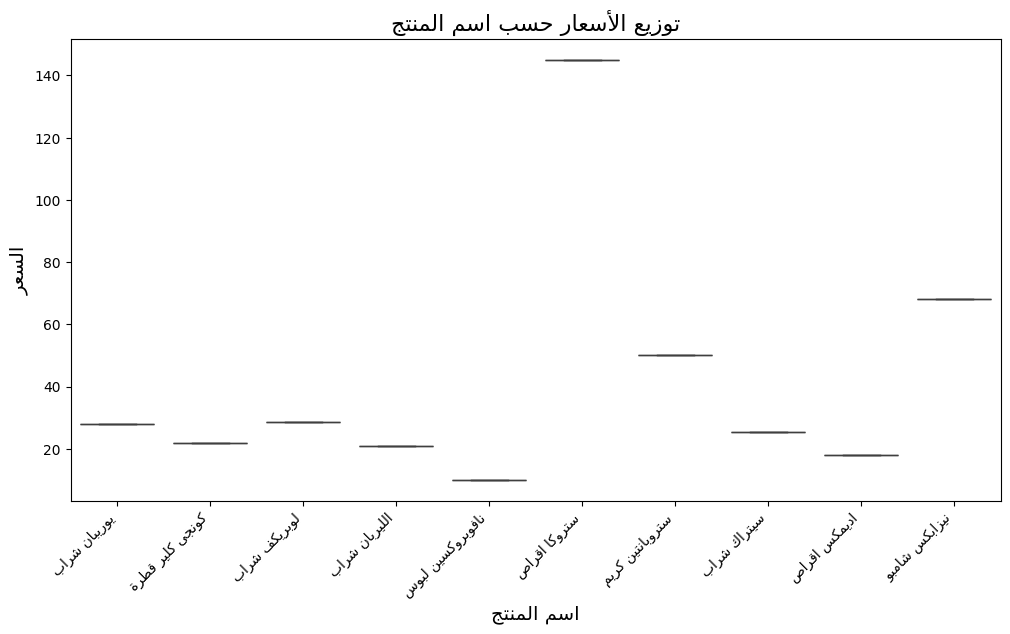

In [8]:
def fix_arabic_text(text):
    return get_display(arabic_reshaper.reshape(text))


top_sellers = df['seller_item_name'].value_counts().nlargest(10).index


df_filtered = df[df['seller_item_name'].isin(top_sellers)].copy()


df_filtered['seller_item_name_fixed'] = df_filtered['seller_item_name'].apply(fix_arabic_text)


plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='seller_item_name_fixed', y='price')


plt.xlabel(fix_arabic_text("اسم المنتج"), fontsize=14)
plt.ylabel(fix_arabic_text("السعر"), fontsize=14)
plt.title(fix_arabic_text("توزيع الأسعار حسب اسم المنتج"), fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.show()


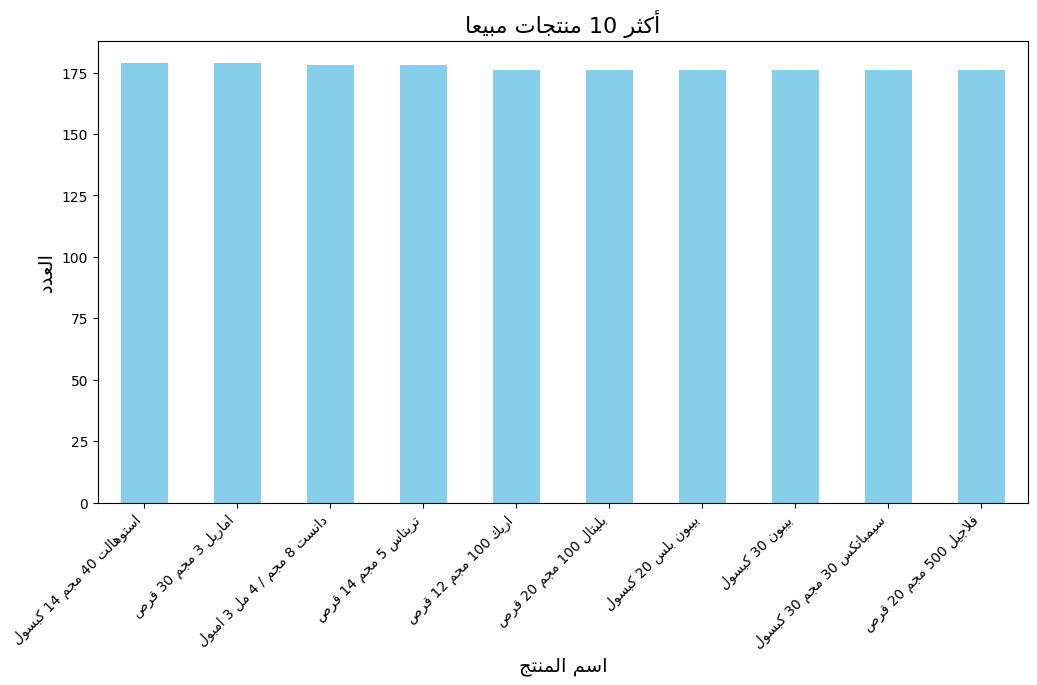

In [9]:
df.columns = df.columns.str.strip()  

if 'marketplace_product_name_ar' not in df.columns:
    print("Error: Column 'marketplace_product_name_ar' not found in the DataFrame!")
else:
    def fix_arabic_text(text):
        return get_display(arabic_reshaper.reshape(str(text)))  

    top_products = df['marketplace_product_name_ar'].value_counts().nlargest(10)

    top_products.index = top_products.index.map(fix_arabic_text)

    # Plot
    plt.figure(figsize=(12, 6))
    top_products.plot(kind='bar', color='skyblue')

    plt.xlabel(fix_arabic_text("اسم المنتج"), fontsize=14)
    plt.ylabel(fix_arabic_text("العدد"), fontsize=14)
    plt.title(fix_arabic_text("أكثر 10 منتجات مبيعًا"), fontsize=16)
    plt.xticks(rotation=45, ha='right')

    plt.show()


# **Shuffling The Taining Dataset To Reduce Overfitting**

In [10]:
df.columns

Index(['sku', 'marketplace_product_name_ar', 'seller_item_name', 'price'], dtype='object')

In [11]:
df = df.sample(frac=1, random_state=40).reset_index(drop=True)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['sku'], random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", val_df.shape)
print("\nTrain DataFrame first rows:\n", train_df.head())


Train DataFrame shape: (66849, 4)
Test DataFrame shape: (16713, 4)

Train DataFrame first rows:
     sku marketplace_product_name_ar          seller_item_name  price
0  1312      موزابرايد 5 مجم 30 قرص   موزابريد 5مج س ج ويسترن   91.5
1  4743     ميكروسيرك 16 مجم 20 قرص  ميكروسيرك16مل ق/العامرية   29.0
2  2517  البافيت كالسيوم شراب 60 مل      البافيت شراب كالسيوم   26.0
3  2374     زيستريل 20 مجم 10 اقراص   زيستريل 20 مجم سعر جديد   52.0
4   639           اتور 10 مجم 7 قرص         اتور 10 مجم اقراص   33.0


# **Preprocessing operations on text  :**

In [12]:
def word_preprocessing(text):
    nltk.download('stopwords')
    arabic_stopwords = set(stopwords.words('arabic'))
    english_stopwords = set(stopwords.words('english'))
    X = []
    for i in range(len(text)):
        statement = text[i].lower()
        
        statement = re.sub(r'[إأآ]', 'ا', statement)  
        statement = re.sub(r'ى', 'ي', statement)  
        statement = re.sub(r'ة', 'ه', statement)  
        statement = re.sub(r'ؤ', 'و', statement)  
        statement = re.sub(r'ئ', 'ي', statement)  
        statement = re.sub(r'ــ', '', statement)
        
        statement = re.sub(r'([\u0600-\u06FF])\1', r'\1', statement)
        
        statement = re.sub(r'(\d+)(?=\D)', r'\1 ', statement)
        statement = re.sub(r'(\D)(\d+)', r'\1 \2', statement)
        
        pattern = '[^\u0621-\u064A0-9a-zA-Z\s]' 
        statement = re.sub(pattern, ' ', statement)
        
        pattern = r"(?<!\d)(.)\1+(?!\d)"
        statement = re.sub(pattern, r"\1", statement)
        
        pattern = r'\b(مل|ملي|مم|جم|مج|مجم|عادي|عاده)\b'
        statement =  re.sub(pattern, '', statement)
        
        
        
        
        pattern = r'\b(اقراص\w*|قرص\w*|شري\w*|كبسول\w*|شرايط|افلام|فيلم|استحلاب|ك|ق)\b'
        statement =  re.sub(pattern, 'قرص', statement)
        
        pattern = r'\bقرص\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'قرص ', statement)        
    
        pattern = r'\bامبول\w*|حقن\w*\b'
        statement = re.sub(pattern, 'امبول', statement)
        
        pattern = r'\bامبول\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'امبول', statement)
        
        pattern = r'جل'
        statement = re.sub(pattern, 'جيل', statement)
        
        pattern = r'\bجيل\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'جيل', statement)
        
        pattern = r'جيل.*غسول'
        statement = re.sub(pattern, 'غسول', statement)
        
        pattern = r'\bغسول\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'غسول', statement)
        
        pattern = r'\bمحلول\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'محلول', statement)
        
        pattern = r'\bلبوس\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'لبوس', statement)
        
        
        pattern = r'قطر\D+'
        statement = re.sub(pattern, r'نقط', statement)
        
        pattern = r'\b(قطره|قطر|نقط|نقطه|قطرهعين)\b'
        statement =  re.sub(pattern, 'نقط', statement)
        
        pattern = r'\bنقط\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'نقط', statement)
        
        pattern = r'\sاكياس|اكيااس'
        statement = re.sub(pattern, 'كيس', statement)
        
        pattern = r'\bكيس\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'كيس', statement)
        
        pattern = r'\b(سبراي|بخاخه)\b'
        statement =  re.sub(pattern, 'بخاخ', statement)
        
        pattern = r'\bبخاخ\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'بخاخ', statement)
        
        pattern = r'مرهم|اكريم'
        statement = re.sub(pattern, 'كريم', statement)
        
        pattern = r'\bكريم\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'كريم', statement)
        
        pattern = r'\b\w*استنشاق\w*\b'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'استنشـاق'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'شـراب+|شرب+|شراب+'
        statement = re.sub(pattern, ' شراب', statement)
        
        pattern = r'\bشراب\s+([^0-9\s]+)\s*'
        statement = re.sub(pattern, 'شراب', statement)
        
        
        
        
        
        
        
        pattern = r'\b[قديم]+\b' 
        statement = re.sub(pattern, '', statement)

        pattern = r'\b[جديد]+\b'
        statement = re.sub(pattern,"", statement)
        
        pattern = r'\b[ء-ي]\b'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'\b[سعر]+\b'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'\bسج|سق\b'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'\b\w*سعر\w*\b'
        statement = re.sub(pattern, '', statement)
        
        pattern = r'\b\w*جدي\w*\b'
        statement = re.sub(pattern, '', statement)
        
        statement = re.sub('mg', '', statement)
        
        words = statement.split()
        filtered_words = [word for word in words if word not in arabic_stopwords and word not in english_stopwords]

        X.append(' '.join(filtered_words))
   
    
    return X

# **Visualizing Most Repeated Products  :**

### Select the font_path that matches your OS and comment the other

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


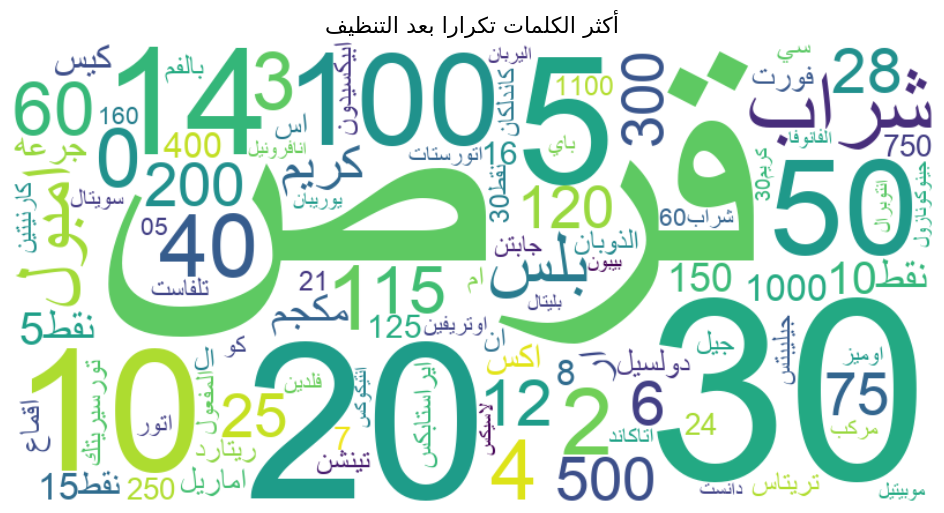

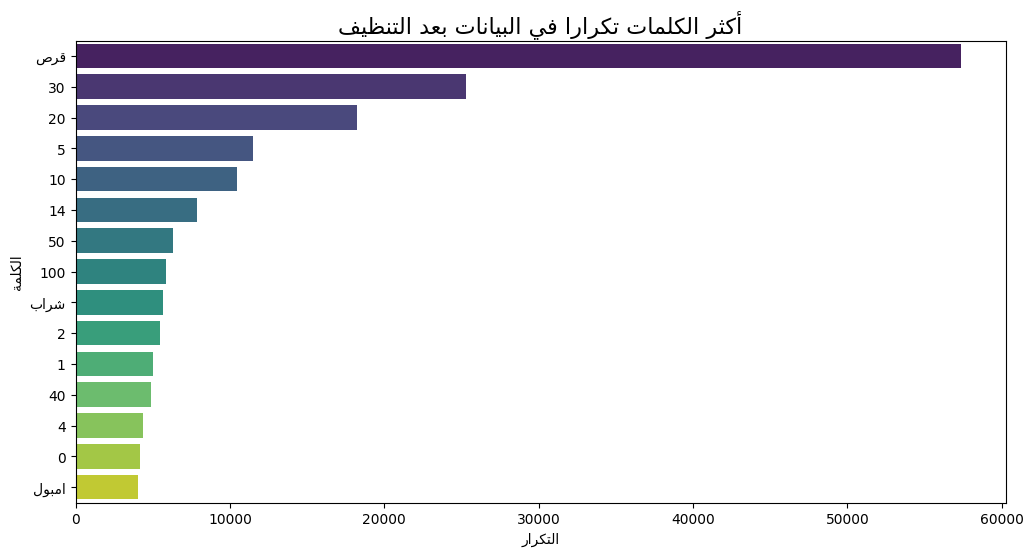

In [13]:
nltk.download("stopwords")

df["clean_text"] = word_preprocessing(df["marketplace_product_name_ar"].astype(str))

all_text = " ".join(df["clean_text"])

words = all_text.split()

word_counts = Counter(words)

word_freq = {get_display(arabic_reshaper.reshape(word)): count for word, count in word_counts.most_common(100)}

plt.figure(figsize=(12, 6))


# font_path = "C:/Windows/Fonts/tahoma.ttf"  # for windows
font_path = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf" # for macOS & linux


wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(get_display(arabic_reshaper.reshape("أكثر الكلمات تكرارًا بعد التنظيف")), fontsize=16)
plt.show()

word_df = pd.DataFrame(word_counts.most_common(15), columns=["Word", "Count"])
word_df["Word"] = word_df["Word"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

plt.figure(figsize=(12, 6))
sns.barplot(data=word_df, y="Word", x="Count", palette="viridis")
plt.xlabel(get_display(arabic_reshaper.reshape("التكرار")))
plt.ylabel(get_display(arabic_reshaper.reshape("الكلمة")))
plt.title(get_display(arabic_reshaper.reshape("أكثر الكلمات تكرارًا في البيانات بعد التنظيف")), fontsize=16)
plt.show()


# **Applying All Preprocessing Operations :**

In [14]:
cv = CountVectorizer()
le = LabelEncoder()

In [15]:
def preparing_train_df(train_df):
    seller_name = train_df['seller_item_name'].apply(str)
    X_train_text = word_preprocessing(seller_name)
    X_train_text = cv.fit_transform(X_train_text).toarray()

    X_train_price = train_df[['price']].values  
    X_train_price = StandardScaler().fit_transform(X_train_price)  

    X_train_combined = np.hstack([X_train_text, X_train_price])  

    y_train = train_df['sku'].values
    y_train = le.fit_transform(y_train)

    return X_train_combined, y_train


In [16]:
def preparing_val_test_df(df):
    seller_name = df['seller_item_name'].apply(str)
    X_test_text = word_preprocessing(seller_name)
    X_test_text = cv.transform(X_test_text).toarray()  

    X_test_price = df[['price']].values  
    X_test_price = StandardScaler().fit_transform(X_test_price)  

    X_test_combined = np.hstack([X_test_text, X_test_price])  

    y_test = df['sku'].values
    y_test = le.transform(y_test)

    return X_test_combined, y_test


In [17]:
def preparing_notmatched_df(df):
    seller_name = df['seller_item_name'].apply(str)
    X_test_text = word_preprocessing(seller_name)
    X_test_text = cv.transform(X_test_text).toarray()  

    X_test_price = df[['price']].values  
    X_test_price = StandardScaler().fit_transform(X_test_price)  

    X_test_combined = np.hstack([X_test_text, X_test_price])  


    return X_test_combined


# **Splitting the Dataet (into train & validation groups) :**

In [18]:
X_train, y_train = preparing_train_df(train_df)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
X_val, y_val  = preparing_val_test_df(val_df)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
X_train.shape[0]


66849

# **Building the Model Architecture (Multilayer Perceptron (MLP)) :**

In [21]:
num_classes = len(set(y_train))  


model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(num_classes, activation='softmax')  
])


optimizer = keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.01)


model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5199 - loss: 3.8259 - val_accuracy: 0.9562 - val_loss: 0.9646 - learning_rate: 5.0000e-04
Epoch 2/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9678 - loss: 0.3387 - val_accuracy: 0.9771 - val_loss: 0.1573 - learning_rate: 5.0000e-04
Epoch 3/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9819 - loss: 0.1714 - val_accuracy: 0.9833 - val_loss: 0.1318 - learning_rate: 5.0000e-04
Epoch 4/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9872 - loss: 0.1256 - val_accuracy: 0.9848 - val_loss: 0.1263 - learning_rate: 5.0000e-04
Epoch 5/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9892 - loss: 0.1070 - val_accuracy: 0.9874 - val_loss: 0.1121 - learning_rate: 5.0000e-04
Epoch 6/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9903 - loss: 0.0954 - val_accuracy: 0.9880 - val_loss: 0.1051 - learning_rate: 5.0000e-04
Epoch 7/150
523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 2

# **Evaluate Model Performance :**

In [22]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_acc:.4f}")

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9981 - loss: 0.0115
Train Accuracy: 0.9979
523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9931 - loss: 0.0515
Validation Accuracy: 0.9925


### Achieving Validation Accuracy arround 99.20%

# **Saving the Model as H5 File :**

In [23]:
model.save("ISUPPLY Product Matching Model with Accuracy 99.25%.h5")

# **Printing The Confidence Score :**

In [24]:
def confidence_score(X_test, y_test):
    probabilities = model.predict(X_test)

    confidence_scores = np.max(probabilities, axis=1)

    predicted_indices = np.argmax(probabilities, axis=1)

    predicted_labels = le.inverse_transform(predicted_indices)

    true_labels = le.inverse_transform(y_test)

    confidence_threshold = 0.9

    test_results = []
    incorrect_count = 0
    high_confidence_count = 0

    for i in range(len(X_test)):
        confidence = confidence_scores[i]
        predicted_class = predicted_labels[i]
        true_class = true_labels[i]

        
        if confidence > confidence_threshold:
            high_confidence_count += 1  
            if predicted_class != true_class:
                incorrect_count += 1  

        if confidence < confidence_threshold:
            predicted_class = "Unknown"

        test_results.append({
            'Predicted': predicted_class
        })
        
    if high_confidence_count > 0:
        error_percentage = (incorrect_count / high_confidence_count) * 100
    else:
        error_percentage = 0.0
        

    temp_df = pd.DataFrame(test_results)
    print(f"Percentage of incorrect classifications with confidence > 0.9: {error_percentage:.2f}%")
    print(temp_df.head())
    return temp_df

In [25]:
temp_df = confidence_score(X_val, y_val)

523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Percentage of incorrect classifications with confidence > 0.9: 0.17%
  Predicted
0       277
1      1795
2      1367
3      1738
4      2529


# **Adding the Predicted Labels :**

In [26]:
predicted_df = val_df

In [27]:
predicted_df['Predicted_sku'] = temp_df['Predicted']
predicted_df.head()

,sku,marketplace_product_name_ar,seller_item_name,price,Predicted_sku
0,277,هاي فريش 0.2 % قطرة عين 10 مل,هاى فريش,75.0,277
1,1795,اوكيوجارد 30 كبسول,اوكيوجارد 30كبسوله,120.0,1795
2,1367,انتيكوكس 15 مجم 30 قرص,انتي كوكس اا 15 30قرص س.ج #,73.5,1367
3,1738,كو افازير قطرة عين 10 مل,كو افازير قطرة,29.0,1738
4,2529,كاردورا 1 مجم 21 قرص,كاردورا 1 مجم اقراص,58.5,2529


# **Saving the Validation Prediction as CSV File (val_prediction.csv):**

In [28]:
predicted_df.to_csv('val_prediction.csv', index=False, encoding='utf-8-sig')

# **Predictions For Test Set :**

#### Input the test DataSet that contains at least : seller_item_name , price and sku columns

In [29]:
# replace the Excel path & the sheet name with the one you want 
test_df = pd.read_excel("Product Matching Dataset.xlsx" , sheet_name="Dataset")  
test_df.head()

,sku,marketplace_product_name_ar,seller_item_name,price
0,1322,استوهالت 40 مجم 14 كبسول,ESTOHALT 40 MG 14 CAP,56.5
1,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
2,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
3,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5
4,1322,استوهالت 40 مجم 14 كبسول,استوهالت 40 مجم 14 ك,56.5


In [30]:
X_test , y_test = preparing_val_test_df(test_df)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9971 - loss: 0.0183
Test Accuracy: 0.9968


In [32]:
temp_df_2 = confidence_score(X_test, y_test)

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Percentage of incorrect classifications with confidence > 0.9: 0.04%
  Predicted
0      1322
1      1322
2      1322
3      1322
4      1322


In [33]:
test_df['Predicted_sku'] = temp_df_2['Predicted']

# **Saving the Testing Prediction as CSV File (test_prediction.csv):**

In [34]:
test_df.to_csv('test_prediction.csv', index=False, encoding='utf-8-sig')